In [26]:
import pandas as pd
import numpy as np
from IPython.core.display import display
import itertools
from matplotlib import pyplot as plt
import os

from parsers import *
from parsers.ipynb_tools import *

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

%matplotlib inline

In [27]:
from IPython.display import set_matplotlib_formats

def plt_to_pdf(size=22):
    set_matplotlib_formats('pdf')
    #font = {'family' : 'Times New Roman',
    #        'weight' : 'normal',
    #        'size'   : size}
    #matplotlib.rc('font', **font)
    
def plt_to_default():
    set_matplotlib_formats('png')
    plt.rcdefaults()

In [28]:
%%HTML
<style type="text/css">
table.dataframe th {
  color: black !important;
}
</style>

In [59]:
experiments = {
    'iwslt17 DE-EN': 'finetune_iwslt17_oversmoothing_grid_label_smoothing_de',
    #'IWSLT17 DE-EN NOLS': 'finetune_iwslt17_oversmoothing_grid_nols_de',
    #'IWSLT17 FR-EN NOLS': 'finetune_iwslt17_oversmoothing_grid_nols_fr',
    'iwslt17 FR-EN': 'finetune_iwslt17_oversmoothing_grid_label_smoothing_fr',
    'iwslt17 ZH-EN': 'finetune_iwslt17_oversmoothing_grid_label_smoothing_zh',
    'wmt19 RU-EN': 'finetune_wmt19_ruen_osl',
    'wmt19 DE-EN': 'finetune_wmt19_deen_osl',
    'wmt19 EN-DE': 'finetune_wmt19_ende_osl',
    'wmt16 EN-DE': 'finetune_wmt16_ende_osl',

}

In [57]:
res = load_experiments_results(experiments, results_dir='/scratch/mae9785/oversmoothing_results_1512/', beam_for_table=1000)

#res = load_experiments_results(experiments, results_dir='/scratch/ik1147/nmt_multiple_eos/nmt_eos/postproc_results', beam_for_table=5)


In [31]:
columns = [
    '$\\alpha$',
    '\\small{iwslt\'17 de-en}',
    '\\small{iwslt\'17 fr-en}',
    '\\small{iwslt\'17 zh-en}',
    '\\small{wmt\'19 ru-en}',
    '\\small{wmt\'19 de-en}',
    '\\small{wmt\'19 en-de}',
    '\\small{wmt\'16 en-de}',

]

In [61]:
import pdb
import collections
from cycler import cycler
from matplotlib.ticker import ScalarFormatter

def generate_bleu_rel_improvement(df):
    baselines = {}
    for i in df.index:
        if df.loc[i, 'OSL weight'] == 0:
            baselines[df.loc[i, 'seed']] = df.loc[i, 'BLEU']
    for i in df.index:
        df.loc[i, 'BLEU rel'] = df.loc[i, 'BLEU'] - baselines[df.loc[i, 'seed']]
        
def generate_bleurt_rel_improvement(df):
    baselines = {}
    for i in df.index:
        if df.loc[i, 'OSL weight'] == 0:
            baselines[df.loc[i, 'seed']] = df.loc[i, 'BLEURT']
    for i in df.index:
        df.loc[i, 'BLEURT rel'] = df.loc[i, 'BLEURT'] - baselines[df.loc[i, 'seed']]

def draw_plots_oversmoothing(experiments, metric, base_path, separately=False, 
                             on_one_plot=False, metric_name=None, target=False, 
                             xaxis_metric=None, beams=(1, 5, 100, 250, 500, 750, 1000), 
                             axis=None, figsize=(7,5), print_title=False):
    to_return = {}
    if separately:
        for i, exp in enumerate(experiments):
            fig, axis = plt.subplots(1, 1, figsize=figsize)
            output = draw_plot_wrt_beam_oversmoothing(axis=axis, exp_name=exp, 
                                                      metric=metric, 
                                                      model_name=experiments[exp], 
                                                      base_path=base_path, metric_name=metric_name,
                                                      target=target, xaxis_metric=xaxis_metric, 
                                                      beams=beams, print_title=print_title, exp_i = i)
            to_return[exp] = output
    elif on_one_plot:
        if axis is None:
            fig, axis = plt.subplots(1, 1, figsize=figsize)
        for i, exp in enumerate(experiments):
            output = draw_plot_wrt_beam_oversmoothing(axis=axis, exp_name=exp, 
                                                      metric=metric, model_name=experiments[exp], 
                                                      base_path=base_path, 
                                                      metric_name=metric_name, 
                                                      target=target, xaxis_metric=xaxis_metric, 
                                                      beams=beams, exp_i = i, print_title=print_title)
            to_return[exp] = output
    else:
        subplots = np.ceil(len(experiments) / 2)
        fig, axes = plt.subplots(int(subplots), 2, figsize=(15, subplots * 7))
        axes = axes.flatten()
        for i, exp in enumerate(experiments):
            output = draw_plot_wrt_beam_oversmoothing(axes[i], exp_name=exp, metric=metric, 
                                                      model_name=experiments[exp], 
                                                      base_path=base_path, 
                                                      metric_name=metric_name, xaxis_metric=xaxis_metric,
                                                      beams=beams, exp_i = i,
                                                      print_title=print_title)
            to_return[exp] = output
    #plt.grid()
    return to_return


def draw_plot_wrt_beam_oversmoothing(axis, metric, model_name, exp_name, base_path, 
                                     metric_name=None, target=False, xaxis_metric=None, 
                                     print_title=False, beams=(1, 5, 100, 250, 500, 750, 1000), exp_i = 0):

    markercycle = ['o', '+', 'x', '*', '.', 'X']
    #axis.set_prop_cycle(colorcycle*markercycle)
    values, stds = {}, {}
    for beam in beams:
        values[beam] = {}
        stds[beam] = {}
        res_path = f'{base_path}/{model_name}/metrics_{model_name}_beam{beam}.csv'
        if not os.path.exists(res_path):
            continue
        metrics = pd.read_csv(res_path, index_col=0)
        if metric == 'BLEU rel':
            generate_bleu_rel_improvement(metrics)
        if metric == 'BLEURT rel':
            generate_bleurt_rel_improvement(metrics)
        res = avg_by_seeds(metrics, params={'OSL weight'}, metrics={metric}, precision=6)
        if xaxis_metric is not None:
            res = avg_by_seeds(metrics, params={'OSL weight'}, metrics={metric, xaxis_metric}, precision=6)
        if len(res) == 0:
            continue
        for i, (weight, value) in enumerate(zip(res['OSL weight'], res[metric])):
            if weight == 1.0:
                continue
            if isinstance(value, str):
                value, std = value.split('+-')
            else:
                value, std = value, 0
            value, std = float(value), float(std)
            xaxis_value = round(weight, 2)
            if xaxis_metric is not None:
                if isinstance(res[xaxis_metric].iloc[i], str):
                    xaxis_value, std = res[xaxis_metric].iloc[i].split('+-')
                else:
                    xaxis_value, std = res[xaxis_metric].iloc[i], 0
                xaxis_value, std = float(xaxis_value), float(std)
                xaxis_value = round(xaxis_value, 2)
            values[beam][xaxis_value] = value
            stds[beam][xaxis_value] = std      
            if metric == 'T False EOS R avg':
                values[beam][xaxis_value] /= dict_size[exp_name]
                stds[beam][xaxis_value] /= dict_size[exp_name]
            if metric == 'OS loss':
                values[beam][xaxis_value] /= test_size[exp_name]
                stds[beam][xaxis_value] /= test_size[exp_name]
    
    y_max_limit = 0
    
    to_return = {}
    for i, beam in enumerate(values):
        values[beam] = collections.OrderedDict(sorted(values[beam].items()))
        stds_down = [values[beam][xaxis_value] - stds[beam][xaxis_value] for xaxis_value in values[beam]]
        stds_up = [values[beam][xaxis_value] + stds[beam][xaxis_value] for xaxis_value in values[beam]]
        if not target:
            axis.plot(values[beam].keys(), values[beam].values(), marker=markercycle[(i+exp_i)%len(markercycle)], label=f'beam {beam}', linewidth=1.2)
        else:
            axis.plot(values[beam].keys(), values[beam].values(), marker=markercycle[(i+exp_i)%len(markercycle)], label=f'{exp_name}', linewidth=1.2)
        #axis.scatter(values[neos].keys(), values[neos].values(), marker='o', label=f'{neos}', s=20 * beam_size[neos])
        if 'WMT' not in exp_name:
            axis.fill_between(values[beam].keys(), stds_down, stds_up, alpha=0.2)
        to_return[beam] = (values[beam].keys(), values[beam].values(), stds_down, stds_up)
        
        if max(values[beam].values()) > y_max_limit:
            y_max_limit = max(values[beam].values())
            

    if metric_name is None:
        metric_name = metric
    axis.set_xlabel('Weight $\\alpha$')
    axis.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 0.95])
    axis.set_xlim(0, 0.95)
    
    if xaxis_metric == 'OS rate':
        axis.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
        axis.set_xlim(0, 0.75)
        
    if metric == 'OS rate':
        axis.set_ylim(0, y_max_limit*1.1)
    
    if metric == 'PPL':
        axis.set_ylim(2.5, 9)
    
    elif metric == 'T NTerm LL Avg':
        axis.set_ylim(-90, -10)
        axis.set_yscale('symlog')
        axis.set_yticks([-10,-20,-30,-40,-50,-60,-70,-80,-90])
        axis.yaxis.set_major_formatter(ScalarFormatter())

        
    elif metric == 'BLEU rel':
        axis.set_yticks([-1, 0, 1, 2, 3])
        axis.set_ylim(-1, 3.05)
    
    elif metric == 'LR seq':
        axis.set_yticks([1, 1.25, 1.5, 1.75, 2, 2.25, 2.4])
        axis.set_ylim(0.99, 2.4)
    
    ylabel_mapping = {
        'OS rate': "Oversmoothing rate",
        'OS loss': "Oversmoothing loss",
        'T False EOS R avg': 'Norm. rank of $\\left<\\mathrm{eos}\\right>$',
        'T NTerm LL Avg': 'Avg. $\\log p(\\left<\\mathrm{eos}\\right>|y_{\\mathrm{prefix}})$',
        'PPL': 'Perplexity',
        '|T|/|G| mean': 'Reference to generated length ratio'
    }
    
    ylabel = ylabel_mapping[metric_name] if metric_name in ylabel_mapping else metric_name
    axis.set_ylabel(ylabel)
    
    if print_title:
        axis.set_title(f'Task: {exp_name}', fontsize=16)
    # use legend
    axis.legend(fontsize=12)
    axis.grid()
    return to_return, axis

def avg_by_seeds(result_df, params, metrics, precision=4):
    unique_values = {}
    for param in params:
        unique_values[param] = result_df[param].unique().tolist()

    grid = (dict(zip(unique_values, x)) for x in itertools.product(*unique_values.values()))
    result = []
    for setup in grid:
        setup_unwrapped = {}
        for param in setup:
            setup_unwrapped[param] = {setup[param]}
        selected_ids = filter_models_df({'res': result_df}, setup_unwrapped)['res']
        result += [setup]
        data = result_df.iloc[selected_ids, :].drop_duplicates('seed')
        for metric in metrics:
            if len(data[metric]) > 1:
                result[-1][metric] = f'{round(data[metric].mean(), precision)} +- {round(data[metric].std(), precision)}'
            else:
                result[-1][metric] = round(data[metric].mean(), precision)
    return pd.DataFrame(result)

In [62]:
dict_size = {
    'iwslt17 DE-EN': 7336,
    'iwslt17 FR-EN': 7368,
    'iwslt17 ZH-EN': 7360,
    'wmt19 RU-EN': 31640,
    'wmt19 DE-EN': 42024,
    'wmt19 EN-DE': 42024,
    'wmt16 EN-DE': 32768
}

test_size = {
    'iwslt17 DE-EN': 8079,
    'iwslt17 FR-EN': 8597,
    'iwslt17 ZH-EN': 8549,
    'wmt19 RU-EN': 2000,
    'wmt19 DE-EN': 2000,
    'wmt19 EN-DE': 2000,
    'wmt16 EN-DE': 3000
}



beam_size = {
    1: 0,
    5: 1,
    100: 2,
    250: 3,
    500: 4,
    750: 5,
    1000: 6
}

In [9]:
def print_table(experiments_results, metric, external=False, maximize=True, highlight=True, return_idxs=False, target=False):
    output = pd.DataFrame()
    columns = []
    for exp in experiments_results:
        columns += [exp]
        if external:
            df = experiments_results[exp][metric]
            output = pd.concat([output, df], axis=1)
        else:
            if target:
                metrics_name = 'metrics_target'
            else:
                metrics_name = 'metrics'
            df = avg_by_seeds(experiments_results[exp][metrics_name],
                              params={'OSL weight'},
                              metrics={metric}).sort_values('OSL weight').set_index('OSL weight')
            df.index.name = None
            output = pd.concat([output, df], axis=1)
    output.columns = columns
    if 'OSL weight' in output.columns:
        output = output.sort_values('OSL weight')
    best_idxs, overlapping_idxs = select_best(output, maximize=maximize)
    if highlight:
        output = output.style.apply(highlight_best(output, best_idxs, overlapping_idxs), axis=1)
    if return_idxs:
        return output, best_idxs, overlapping_idxs
    return output

def select_best(df, maximize=True):
    print(df.iloc[0, 0])
    def is_better(a, b):
        if maximize:
            return a > b
        else:
            return b > a

    invert = 1
    if not maximize:
        invert = -1
    best_mean = [invert * -np.inf] * df.columns.size
    std_for_best_mean = [0] * df.columns.size
    idx_for_best_mean = [''] * df.columns.size
    
    for i in range(1):
        for j in range(df.columns.size):
            if isinstance(df.iloc[i, j], str) and '+-' in df.iloc[i, j]:
                mean_str, std_str = df.iloc[i, j].split(' +- ')
                mean, std = float(mean_str), float(std_str)
            else:
                mean = float(df.iloc[i, j])
                std = 0
            best_mean[j] = mean
            std_for_best_mean[j] = std
            idx_for_best_mean[j] = i

    lower_values = [best_mean[k] - std_for_best_mean[k] for k in range(df.columns.size)]
    
    overlapping_idxs = [set() for i in range(df.columns.size)]
    for i in range(df.index.size - 1):
        for j in range(df.columns.size):
            if i == idx_for_best_mean[j]:
                continue
            if isinstance(df.iloc[i, j], str) and '+-' in df.iloc[i, j]:
                mean_str, std_str = df.iloc[i, j].split(' +- ')
                mean, std = float(mean_str), float(std_str)
            else:
                mean = float(df.iloc[i, j])
                std = 0
            if mean + std < lower_values[j]:
                overlapping_idxs[j].add(i)

    return idx_for_best_mean, overlapping_idxs

def highlight_best(df, best_idx, overlapping_idxs):
    standard_style = 'border: 1px  black solid; text-align:center !important; color: black !important;'
    row_number = 0
    def color_to_highlight(row):
        nonlocal row_number
        style = []
        for i in range(df.columns.size):
            if best_idx[i] == row_number:
                style += [f'background-color: lightgreen; {standard_style}']
            elif row_number in overlapping_idxs[i]:
                style += [f'background-color: lightyellow; {standard_style}']
            else:
                style += [standard_style]
        row_number += 1
        return style
    return color_to_highlight


In [18]:
import matplotlib.font_manager
plt_to_pdf(16)

/state/partition1/job-13078227/ipykernel_1324639/4099449698.py:4: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf')


In [41]:
plt_to_default()

/state/partition1/job-13078227/ipykernel_1324639/4099449698.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png')


In [12]:
12 % 10

2

### List of metrics

In [14]:
res['iwslt17 DE-EN']['metrics'].columns

Index(['beam', 'seed', 'OSL weight', 'OSL Margin', 'BLEU', 'BLEURT', 'PPL',
       'NLL', 'Abrupted', 'OS rate', 'OS loss', 'Target Empty WR',
       'Generated Empty WR', '|T|/|G| mean', '|T|/|G| med',
       'T False EOS R avg', 'T True EOS R avg', 'T Term LL Avg',
       'T NTerm LL Avg'],
      dtype='object')

In [9]:
matplotlib.__version__

'3.4.3'

### Single plot for all tasks (any beam for the target metric works)

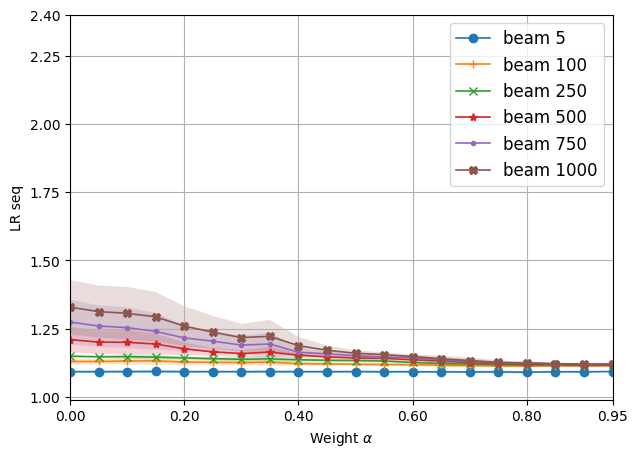

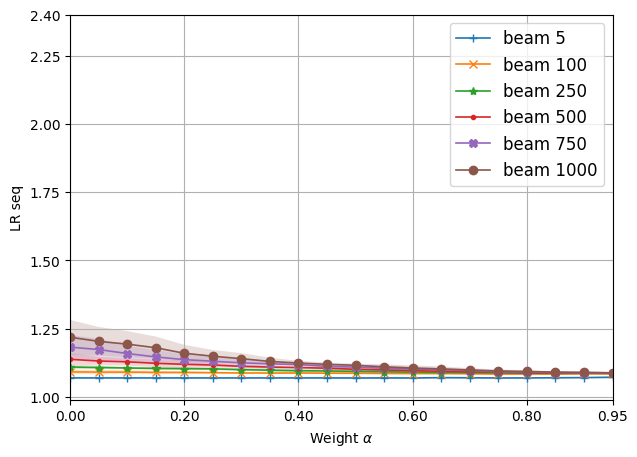

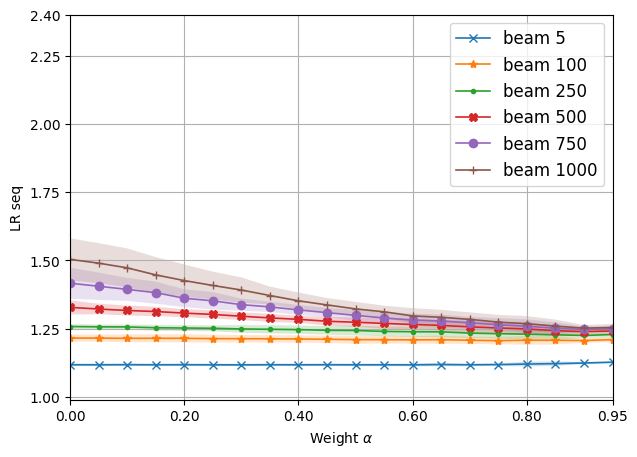

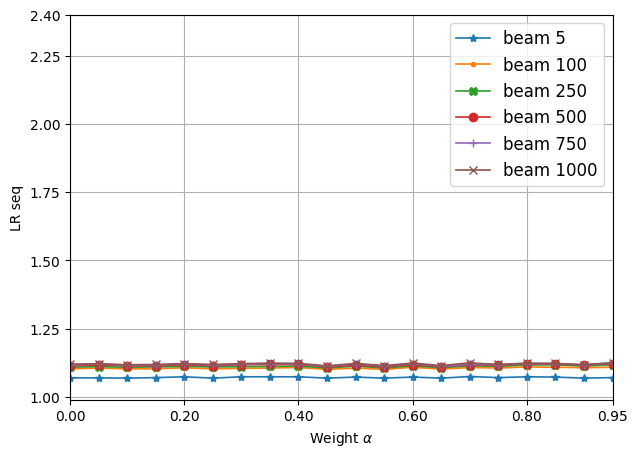

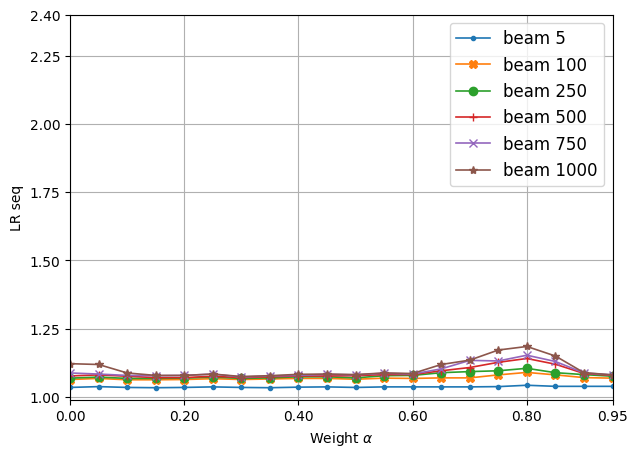

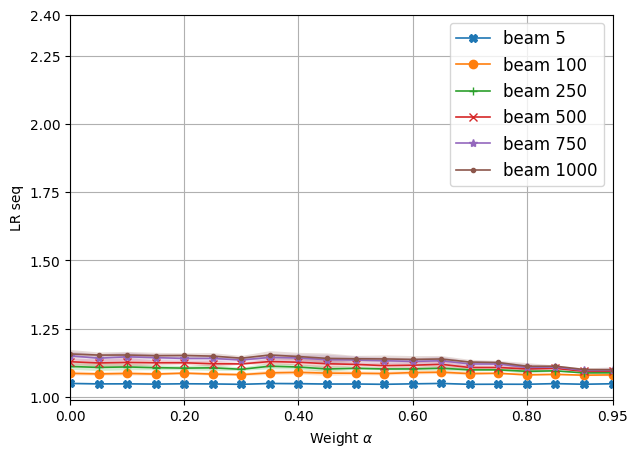

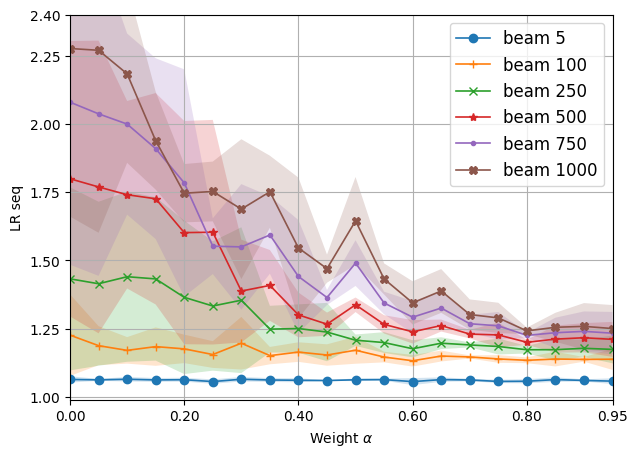

In [63]:
t = draw_plots_oversmoothing(experiments, 'LR seq', on_one_plot=False, 
                             base_path='/scratch/mae9785/oversmoothing_results_1512/', 
                             target=False,  beams=(5, 100, 250, 500, 750, 1000), separately=True,
                             print_title=False)

### Different plots for different tasks with several beams on each (one figure)

In [38]:
t = draw_plots_oversmoothing(experiments, 'LR seq', on_one_plot=True, 
                             base_path='/scratch/mae9785/oversmoothing_results_1512/', 
                             target=False, metric_name='Length ratio', 
                             beams=(100,), separately=False)

<Figure size 504x360 with 1 Axes>

### Several separate figures for different tasks (good for PDFs)

In [48]:
plt_to_pdf(12)

wmt_experiments = {
 'wmt19 RU-EN': 'finetune_wmt19_ruen_osl',
 'wmt19 DE-EN': 'finetune_wmt19_deen_osl',
 'wmt16 EN-DE': 'finetune_wmt16_ende_osl',}

t = draw_plots_oversmoothing(experiments, '|T|/|G| mean', on_one_plot=True, 
                             base_path='/scratch/ik1147/nmt_multiple_eos/nmt_eos/postproc_results', 
                             target=True, beams=(1000,), metric_name='BLEURT improvement', separately=False, figsize=(4,5))
plt.tight_layout()

<Figure size 288x360 with 1 Axes>

In [105]:
experiments

{'iwslt17 DE-EN': 'finetune_iwslt17_oversmoothing_grid_label_smoothing_de',
 'iwslt17 FR-EN': 'finetune_iwslt17_oversmoothing_grid_label_smoothing_fr',
 'iwslt17 ZH-EN': 'finetune_iwslt17_oversmoothing_grid_label_smoothing_zh',
 'wmt19 RU-EN': 'finetune_wmt19_ruen_osl',
 'wmt19 DE-EN': 'finetune_wmt19_deen_osl',
 'wmt16 EN-DE': 'finetune_wmt16_ende_osl'}

### Tables w/ highlights

In [58]:
print_table(res, 'LR seq', external=False, highlight=True)

,wmt19 RU-EN,wmt19 DE-EN,wmt19 EN-DE,wmt16 EN-DE
0.0,1.12,1.122,1.1578 +- 0.0146,2.2762 +- 0.6156
0.05,1.122,1.119,1.1534 +- 0.0098,2.2698 +- 0.6683
0.1,1.118,1.088,1.1538 +- 0.0114,2.1835 +- 0.326
0.15,1.119,1.079,1.1514 +- 0.0104,1.9387 +- 0.1792
0.2,1.122,1.079,1.1522 +- 0.0077,1.7463 +- 0.1068
0.25,1.119,1.084,1.1496 +- 0.0111,1.7527 +- 0.1095
0.3,1.122,1.075,1.1422 +- 0.008,1.688 +- 0.256
0.35,1.124,1.078,1.1538 +- 0.014,1.7517 +- 0.132
0.4,1.123,1.083,1.1482 +- 0.0134,1.5457 +- 0.2576
0.45,1.114,1.084,1.1414 +- 0.0183,1.47 +- 0.0514


In [56]:
print_table(res, '|T|/|G| mean', external=False, highlight=True)

,wmt19 RU-EN,wmt19 DE-EN,wmt19 EN-DE,wmt16 EN-DE
0.0,1.07,1.035,1.0496 +- 0.0025,1.0642 +- 0.0114
0.05,1.07,1.038,1.048 +- 0.0031,1.0628 +- 0.0036
0.1,1.069,1.035,1.0482 +- 0.0026,1.065 +- 0.0083
0.15,1.071,1.034,1.0472 +- 0.0016,1.0625 +- 0.007
0.2,1.074,1.035,1.0484 +- 0.0011,1.0632 +- 0.0071
0.25,1.069,1.037,1.0478 +- 0.0016,1.0565 +- 0.0081
0.3,1.074,1.035,1.0464 +- 0.0022,1.065 +- 0.0083
0.35,1.074,1.034,1.0494 +- 0.0022,1.0622 +- 0.0069
0.4,1.074,1.036,1.0488 +- 0.0033,1.0612 +- 0.0075
0.45,1.069,1.037,1.0474 +- 0.0034,1.0603 +- 0.0015


In [95]:
print_table(res, 'PPL', external=False, highlight=True, maximize=False)

4.996 +- 0.0279


,iwslt17 DE-EN,iwslt17 FR-EN,iwslt17 ZH-EN,wmt19 RU-EN,wmt19 DE-EN,wmt19 EN-DE,wmt16 EN-DE
0.0,4.996 +- 0.0279,3.988 +- 0.0589,8.426 +- 0.1563,3.070000,2.820000,2.708 +- 0.0084,4.4167 +- 0.0321
0.05,4.998 +- 0.0259,3.988 +- 0.0589,8.426 +- 0.1563,3.060000,2.810000,2.712 +- 0.0084,4.4067 +- 0.0231
0.1,4.998 +- 0.0259,3.988 +- 0.0589,8.426 +- 0.1563,3.070000,2.820000,2.704 +- 0.0089,4.4533 +- 0.0252
0.15,4.998 +- 0.0259,3.988 +- 0.0589,8.426 +- 0.1563,3.070000,2.810000,2.708 +- 0.0084,4.4133 +- 0.0153
0.2,4.998 +- 0.0259,3.988 +- 0.0589,8.426 +- 0.1563,3.030000,2.810000,2.71 +- 0.0071,4.4 +- 0.0458
0.25,4.998 +- 0.0259,3.988 +- 0.0589,8.426 +- 0.1563,3.070000,2.810000,2.7 +- 0.0071,4.4467 +- 0.0252
0.3,4.998 +- 0.0259,3.988 +- 0.0589,8.426 +- 0.1563,3.060000,2.810000,2.702 +- 0.0084,4.44 +- 0.0173
0.35,4.998 +- 0.0259,3.988 +- 0.0589,8.426 +- 0.1563,3.060000,2.810000,2.702 +- 0.0084,4.4533 +- 0.0611
0.4,4.998 +- 0.0259,3.988 +- 0.0589,8.426 +- 0.1563,3.030000,2.800000,2.702 +- 0.0084,4.4167 +- 0.0153
0.45,4.998 +- 0.0259,3.988 +- 0.0589,8.426 +- 0.1563,3.020000,2.800000,2.7 +- 0.01,4.42 +- 0.0265


In [42]:
def create_internal_metric_latex(results, metric, columns, maximize=False, highlight=False,
                                 dest_dir=None, external=False, precision=2):
    df, best_idxs, overlapping_idxs = print_table(results, metric, external=external,
                                                  maximize=maximize, highlight=False,
                                                  return_idxs=True)
    column_row = ' &'.join(columns) + '\\\\ \\midrule'

    table_header = """
    \\begin{{table*}}[]
    \\begin{{tabular}}{{{}}}
    \\toprule

    {}
    """.format(('l' * (len(columns) + 1))[:-1], column_row)

    for i, row_name in enumerate(df.index):
        current_row = f'{row_name} '
        for j, column_name in enumerate(df.columns):
            value = df.iloc[i, j]
            if isinstance(value, str) and '+-' in value:
                mean, std = value.split(' +- ')
            else:
                mean = value
                std = '0'
            mean = round(float(mean), precision)
            std = round(float(std), precision)
            if highlight and (i in overlapping_idxs[j]):
                mean = '\\textbf{{{}}}'.format(mean)
            if std > 0:
                value_latex = '{} \\scriptsize{{$\pm$ {}}}'.format(mean, std)
            else:
                value_latex = '{}'.format(mean)
            current_row += f" & {value_latex}"
        table_header += f' {current_row} \\\\ \n'

    table_header += """
    \\bottomrule
    \\end{tabular}
    \\caption{}
    \\end{table*}
    """

    if dest_dir is not None:
        metric = metric.replace('/', '_')
        metric = metric.replace('|', '')
        metric = metric.lower()
        metric = metric.replace(' ', '_')
        save_path = f'{dest_dir}/{metric}.tex'
        with open(save_path, 'w') as f:
            f.write(table_header)

    return table_header

### Latex tables

In [94]:
print(create_internal_metric_latex(res, 'PPL', columns=columns, highlight=True, maximize=True, precision=3))

4.996 +- 0.0279

    \begin{table*}[]
    \begin{tabular}{llllllll}
    \toprule

    $\alpha$ &\small{iwslt'17 de-en} &\small{iwslt'17 fr-en} &\small{iwslt'17 zh-en} &\small{wmt'19 ru-en} &\small{wmt'19 de-en} &\small{wmt'19 en-de} &\small{wmt'16 en-de}\\ \midrule
     0.0  & 4.996 \scriptsize{$\pm$ 0.028} & 3.988 \scriptsize{$\pm$ 0.059} & 8.426 \scriptsize{$\pm$ 0.156} & 3.07 & 2.82 & 2.708 \scriptsize{$\pm$ 0.008} & 4.417 \scriptsize{$\pm$ 0.032} \\ 
 0.05  & 4.998 \scriptsize{$\pm$ 0.026} & 3.988 \scriptsize{$\pm$ 0.059} & 8.426 \scriptsize{$\pm$ 0.156} & \textbf{3.06} & \textbf{2.81} & 2.712 \scriptsize{$\pm$ 0.008} & 4.407 \scriptsize{$\pm$ 0.023} \\ 
 0.1  & 4.998 \scriptsize{$\pm$ 0.026} & 3.988 \scriptsize{$\pm$ 0.059} & 8.426 \scriptsize{$\pm$ 0.156} & 3.07 & 2.82 & 2.704 \scriptsize{$\pm$ 0.009} & 4.453 \scriptsize{$\pm$ 0.025} \\ 
 0.15  & 4.998 \scriptsize{$\pm$ 0.026} & 3.988 \scriptsize{$\pm$ 0.059} & 8.426 \scriptsize{$\pm$ 0.156} & 3.07 & \textbf{2.81} & 2.708 \script

In [15]:
import torch

In [43]:
num_updates = []

for i in range(1, 106):
    if i % 10 == 0:
        print(i)
    ckpt = torch.load(f'/scratch/mae9785/nmt/finetune_iwslt17_oversmoothing_grid_label_smoothing_zh/sweep_step_{i}/checkpoint_best.pt')
    num_updates += [ckpt['optimizer_history'][1]['num_updates']]

10
20
30
40
50
60
70
80
90
100


In [44]:
np.mean(num_updates)

4699.647619047619

In [45]:
num_updates = []

for i in range(1, 106):
    if i % 10 == 0:
        print(i)
    ckpt = torch.load(f'/scratch/mae9785/nmt/finetune_iwslt17_oversmoothing_grid_label_smoothing_de/sweep_step_{i}/checkpoint_best.pt')
    num_updates += [ckpt['optimizer_history'][1]['num_updates']]

10
20
30
40
50
60
70
80
90
100


In [46]:
np.mean(num_updates)

4690.476190476191

In [47]:
num_updates = []

for i in range(1, 106):
    if i % 10 == 0:
        print(i)
    ckpt = torch.load(f'/scratch/mae9785/nmt/finetune_iwslt17_oversmoothing_grid_label_smoothing_fr/sweep_step_{i}/checkpoint_best.pt')
    num_updates += [ckpt['optimizer_history'][1]['num_updates']]

10
20
30
40
50
60
70
80
90
100


In [48]:
np.mean(num_updates)

6926.628571428571

In [49]:
num_updates = []

for i in range(1, 22):
    if i % 10 == 0:
        print(i)
    ckpt = torch.load(f'/scratch/ratch/ratch/ratch/ik1147/nmt_multiple_eos/nmt_eos/finetune_wmt19_deen_osl/sweep_step_{i}/checkpoint_best.pt')
    num_updates += [ckpt['optimizer_history'][1]['num_updates']]

10
20


In [50]:
np.mean(num_updates)

47809.52380952381

In [51]:
num_updates = []

for i in range(1, 22):
    if i % 10 == 0:
        print(i)
    ckpt = torch.load(f'/scratch/ik1147/nmt_multiple_eos/nmt_eos/finetune_wmt19_ruen_osl/sweep_step_{i}/checkpoint_best.pt')
    num_updates += [ckpt['optimizer_history'][1]['num_updates']]

10
20


In [52]:
np.mean(num_updates)

76380.95238095238

In [53]:
num_updates = []

for i in range(1, 22):
    if i % 10 == 0:
        print(i)
    ckpt = torch.load(f'/scratch/ik1147/nmt_multiple_eos/nmt_eos/finetune_wmt19_ende_osl/sweep_step_{i}/checkpoint_best.pt')
    num_updates += [ckpt['optimizer_history'][1]['num_updates']]

10
20


In [54]:
np.mean(num_updates)

44857.142857142855

In [55]:
num_updates = []

for i in range(1, 22):
    if i % 10 == 0:
        print(i)
    ckpt = torch.load(f'/scratch/ik1147/nmt_multiple_eos/nmt_eos/finetune_wmt16_ende_osl/sweep_step_{i}/checkpoint_best.pt')
    num_updates += [ckpt['optimizer_history'][1]['num_updates']]

10
20


In [56]:
np.mean(num_updates)

12000.0

In [14]:
pip freeze 

absl-py==0.13.0
alabaster==0.7.12
antlr4-python3-runtime==4.8
argon2-cffi @ file:///tmp/build/80754af9/argon2-cffi_1613037499734/work
astunparse==1.6.3
async-generator @ file:///home/ktietz/src/ci/async_generator_1611927993394/work
asyncio==3.4.3
attrs @ file:///tmp/build/80754af9/attrs_1620827162558/work
Babel==2.9.1
backcall @ file:///home/ktietz/src/ci/backcall_1611930011877/work
bitarray==2.3.4
bleach @ file:///tmp/build/80754af9/bleach_1628110601003/work
BLEURT @ file:///home/mae9785/bleurt
boto3==1.20.18
botocore==1.23.18
cachetools==4.2.2
catboost==1.0.0
certifi==2021.10.8
cffi @ file:///tmp/build/80754af9/cffi_1625814692085/work
charset-normalizer==2.0.6
clang==5.0
click==8.0.1
colorama==0.4.4
compare-mt @ file:///home/mae9785/bleurt/compare-mt
cycler==0.10.0
Cython==0.29.24
debugpy @ file:///tmp/build/80754af9/debugpy_1629214122703/work
decorator==5.1.0
deepreplay==0.1.2a2
defusedxml @ file:///tmp/build/80754af9/defusedxml_1615228127516/work
docopt==0.6.2
docutils==0.17.1
edit